In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils.load_brad_trace import load_trace, create_concurrency_dataset, load_trace_all_version
from models.concurrency.analytical_models import SimpleFitCurve, ComplexFitCurve
from models.concurrency.xgboost import XGBoostPredictor
from models.concurrency.linear_regression import SimpleLinearReg
np.set_printoptions(suppress=True)

In [16]:
all_df = []
for n_nodes in [1, 2, 4, 8]:
    isolated_trace_df = pd.read_csv(f"/Users/ziniuw/Desktop/research/Data/AWS_trace/redshift_scale/repeating_olap_batch_warmup_{n_nodes}_nodes.csv")
    all_df.append(isolated_trace_df)
with open("/Users/ziniuw/Desktop/research/Data/AWS_trace/redshift_scale/redshift_long.sql", "r") as f:
    queries = f.readlines()

In [5]:
df = all_df[0]
df.columns

Index(['timestamp', 'query_idx', 'run_time_s', 'engine'], dtype='object')

In [80]:
def get_first_time_runtime(df, num_queries):
    first_run = np.zeros(num_queries) + 1500
    other_runs = np.zeros(num_queries) + 1500
    for i, rows in df.groupby("query_idx"):
        first_run[i] = rows['run_time_s'].values[0]
        other_runs[i] = np.mean(rows['run_time_s'].values[1:])
    return first_run, other_runs

def plot_per_query_runtime(idx, all_first_run, all_other_runs, savefig=False):
    bar_1 = [all_first_run[0][idx], all_other_runs[0][idx]]
    bar_2 = [all_first_run[1][idx], all_other_runs[1][idx]]
    bar_4 = [all_first_run[2][idx], all_other_runs[2][idx]]
    bar_8 = [all_first_run[3][idx], all_other_runs[3][idx]]

    plt.figure(figsize=(7,4))
    N = 2
    ind = np.arange(N)
    plt.bar(ind-width, bar_1, width, label='1 node')
    plt.bar(ind, bar_2, width, label='2 nodes')
    plt.bar(ind+width, bar_4, width, label='4 nodes')
    plt.bar(ind+2*width, bar_8, width, label='8 nodes')
    plt.xticks(ind + width / 2, ('Runtime w. compilation', 'Runtime w/o compilation'))
    plt.legend(loc='best')
    if savefig:
        plt.savefig(f"query_{idx}.pdf")
    else:
        plt.show()

In [61]:
all_first_run = []
all_other_runs = []
all_compilation_time = []
for df in all_df:
    print("=======================================================")
    first_run, other_runs = get_first_time_runtime(df, len(queries))
    all_first_run.append(first_run)
    all_other_runs.append(other_runs)
    print(np.mean(first_run), np.std(first_run), np.mean(other_runs), np.std(other_runs))
    compilation_time = np.maximum(first_run - other_runs, 0)
    all_compilation_time.append(compilation_time)
    print(np.mean(compilation_time), np.std(compilation_time))

49.6147327035387 104.57417950660319 43.482906796664835 100.78226588153824
6.396573952536716 12.689572140973977
50.99966456845542 88.5023621028326 27.08748417970176 85.94666485214248
24.048966143732873 24.299823221984845
63.08315122127533 35.32285749152943 22.221511077212398 28.376524714170593
41.00088849580177 23.81778094901943
59.78438030648454 27.779996781395045 13.674985433738922 19.257059999236404
46.14723287642559 22.40976935467908


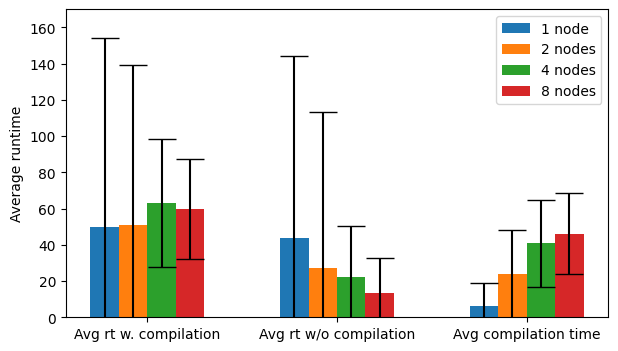

In [37]:
N = 3
bar_1 = (49.6147327035387, 43.482906796664835, 6.13)
err_1 = (104.57, 100.78, 12.89)
bar_2 = (50.99966456845542, 27.08748417970176, 23.91)
err_2 = (88.50, 85.94, 24.49)
bar_4 = (63.08315122127533, 22.221511077212398, 40.86)
err_4 = (35.32, 28.37, 24.08)
bar_8 = (59.78438030648454, 13.674985433738922, 46.11)
err_8 = (27.77, 19.25, 22.49)

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(7,4))

# Width of a bar 
width = 0.15

# Plotting
plt.bar(ind-width, bar_1, width, yerr=err_1, label='1 node', capsize=10)
plt.bar(ind, bar_2, width, yerr=err_2, label='2 nodes', capsize=10)
plt.bar(ind+width, bar_4, width, yerr=err_4, label='4 nodes', capsize=10)
plt.bar(ind+2*width, bar_8, width, yerr=err_8, label='8 nodes', capsize=10)

plt.ylim(0, 170)
#plt.xlabel('Here goes x-axis label')
plt.ylabel('Average runtime')
#plt.title('')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('Avg rt w. compilation', 'Avg rt w/o compilation', 'Avg compilation time'))

# Finding the best position for legends and putting it
plt.legend(loc='best')
#plt.savefig("nodes.pdf")
plt.show()

171


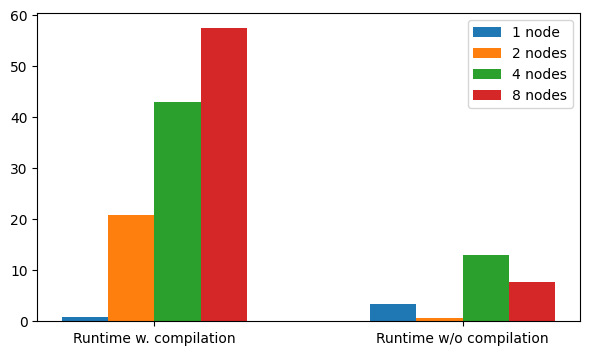

208


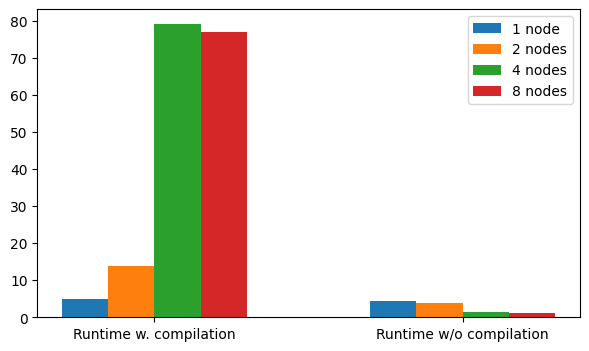

410


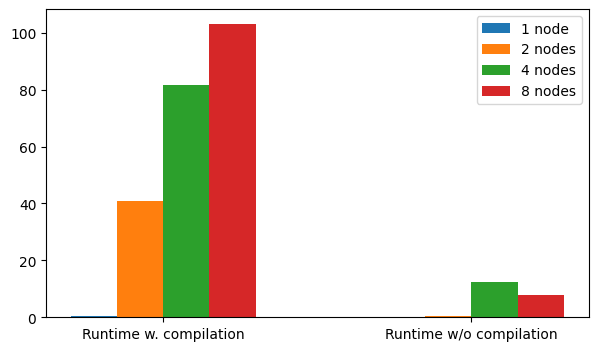

701


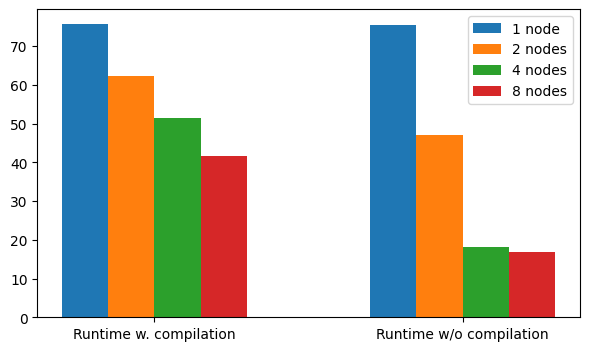

789


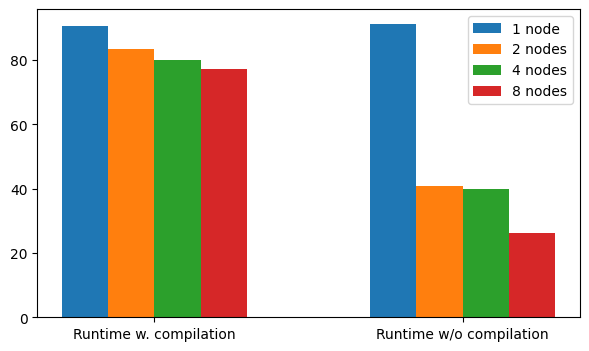

168


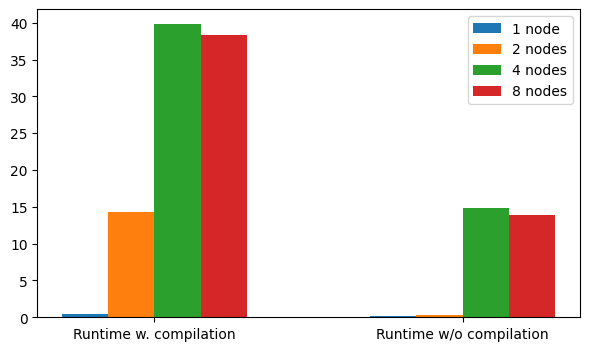

996


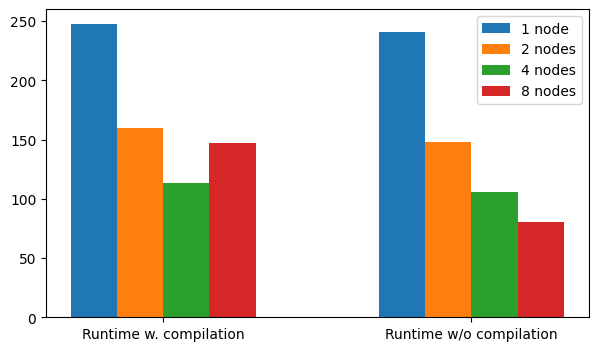

282


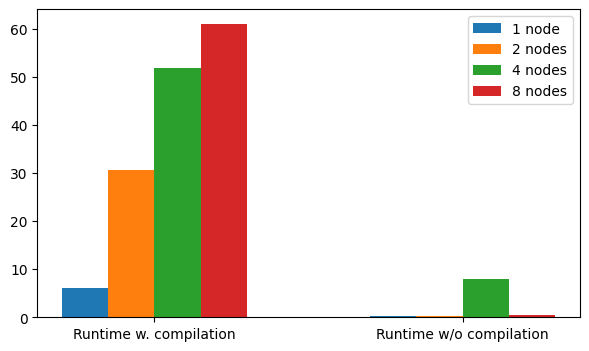

672


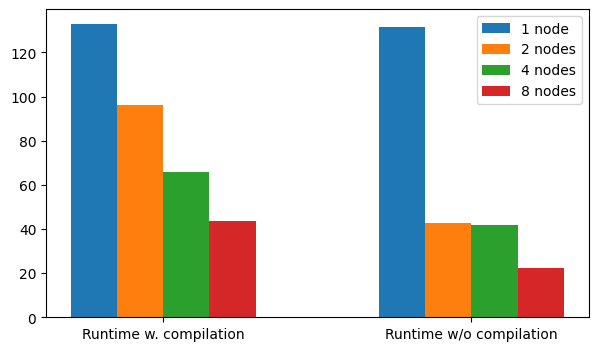

201


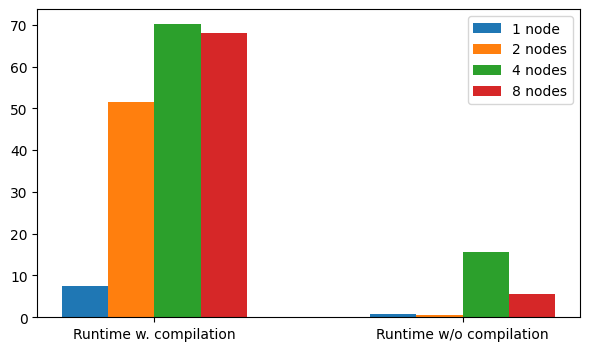

607


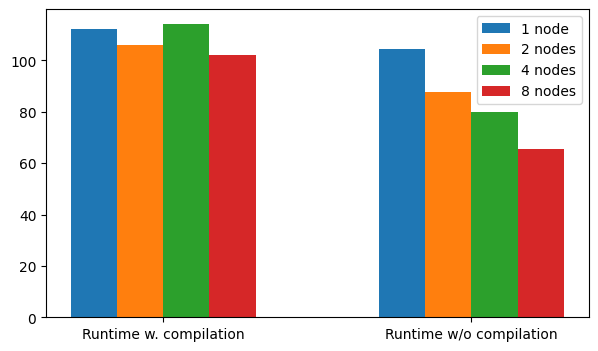

111


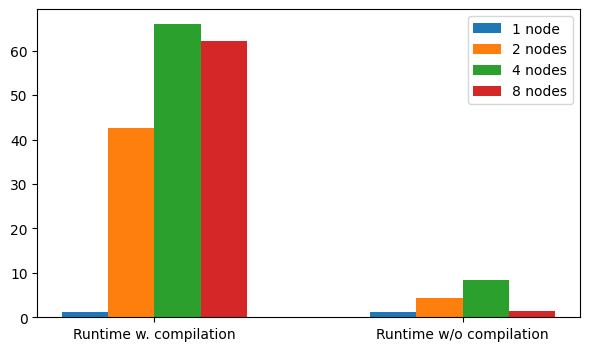

263


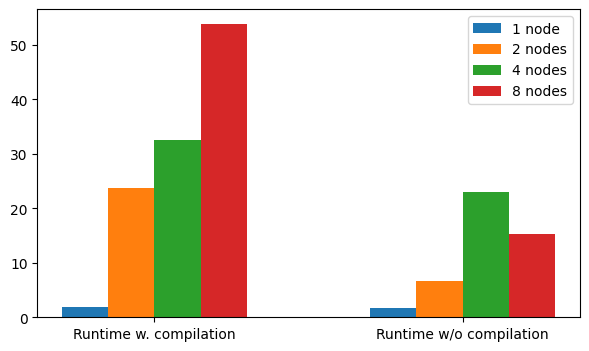

586


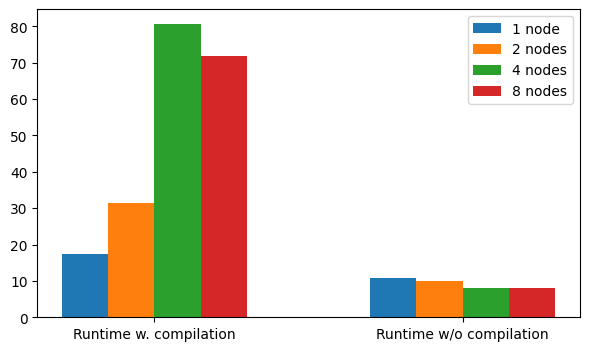

802


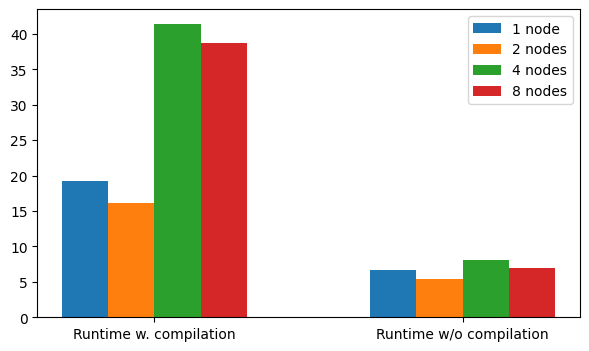

381


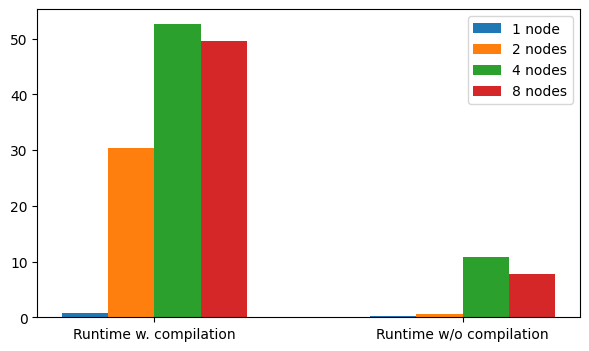

414


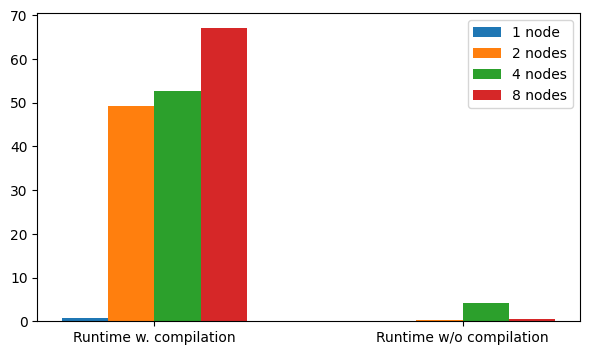

451


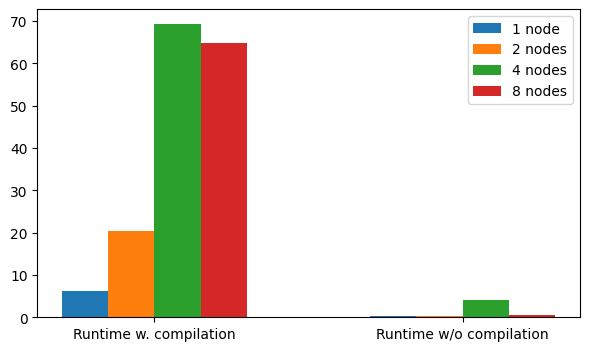

600


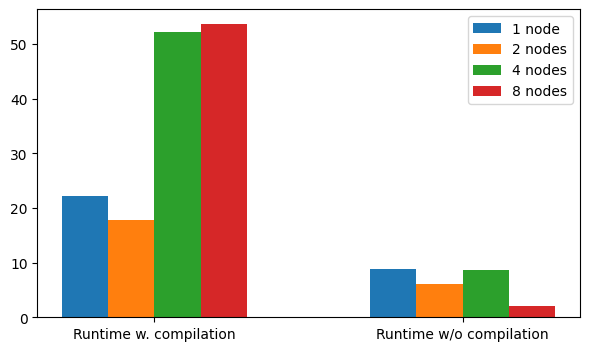

730


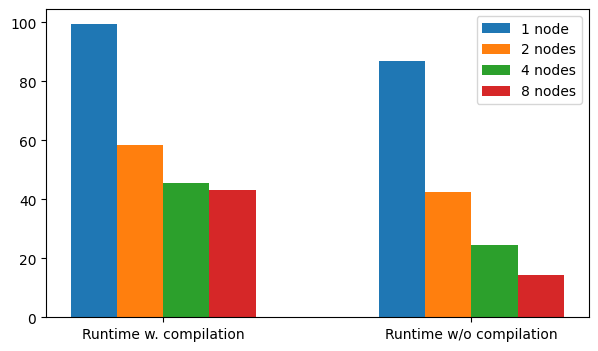

548


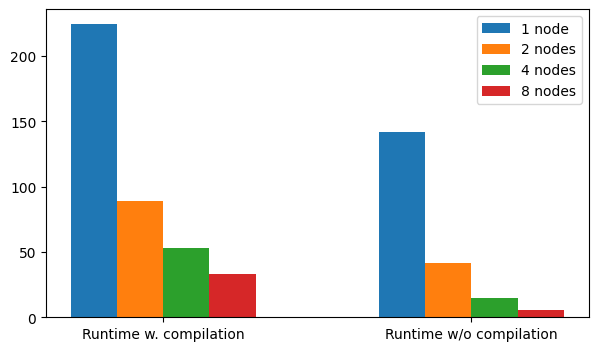

252


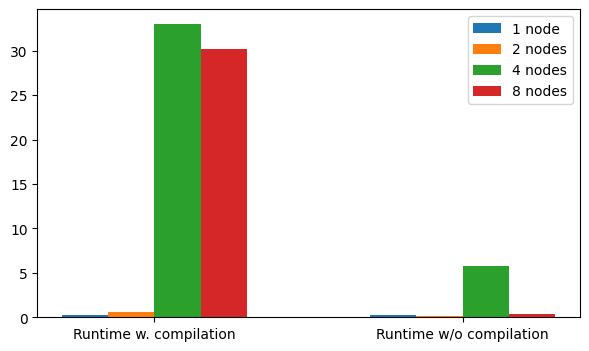

484


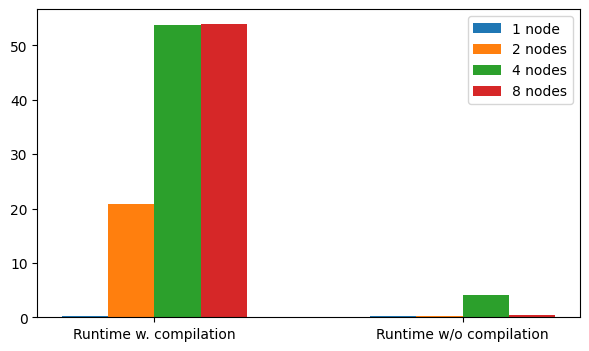

497


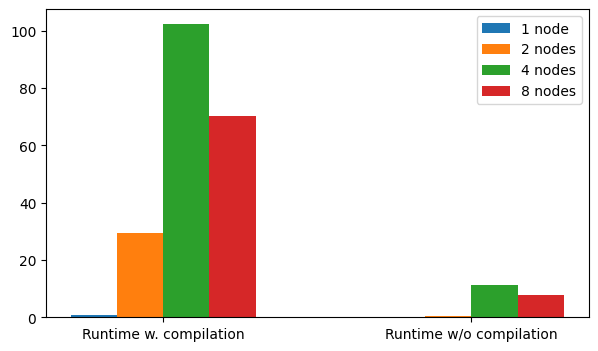

362


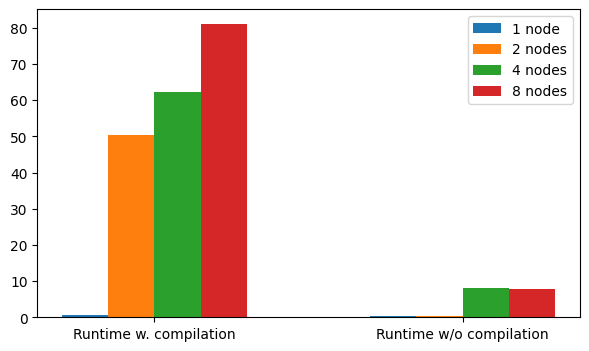

482


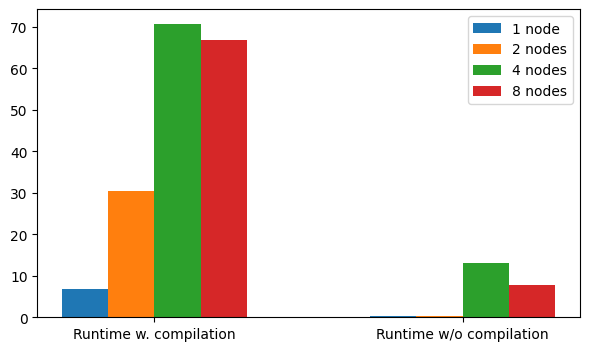

1036


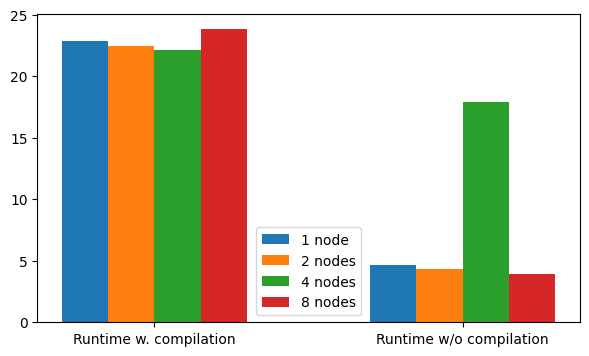

235


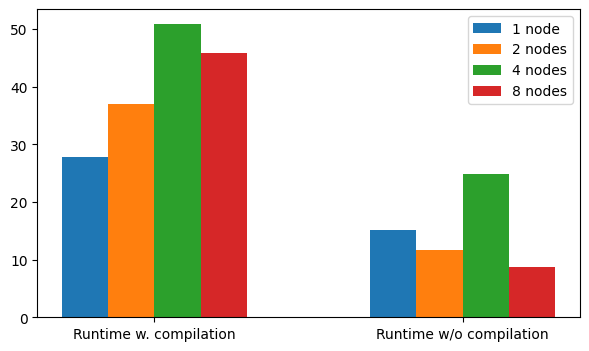

277


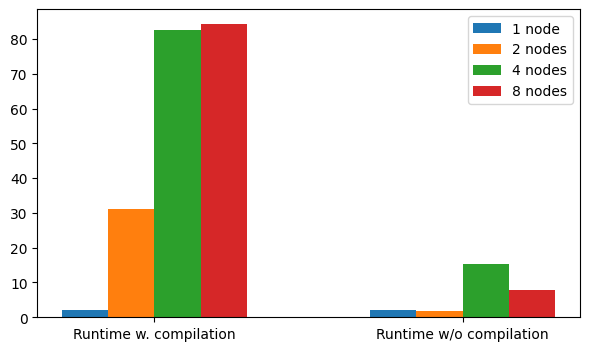

44


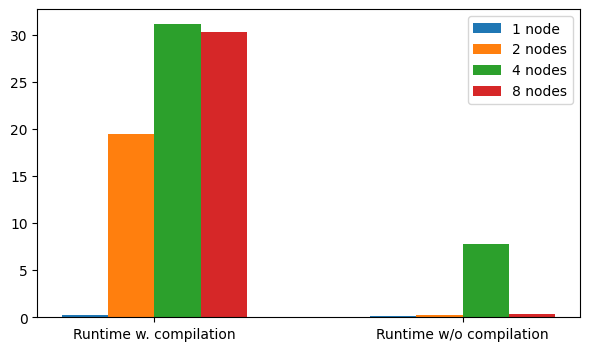

In [79]:
for i in np.random.randint(0, len(queries), size=30):
    print(i)
    plot_per_query_runtime(i, all_first_run, all_other_runs)

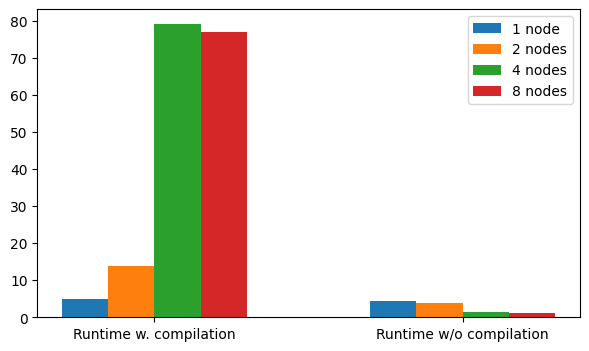

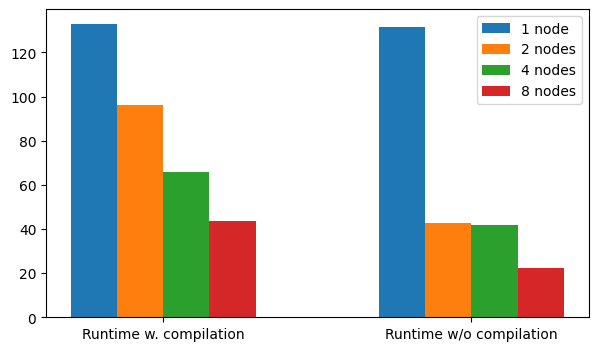

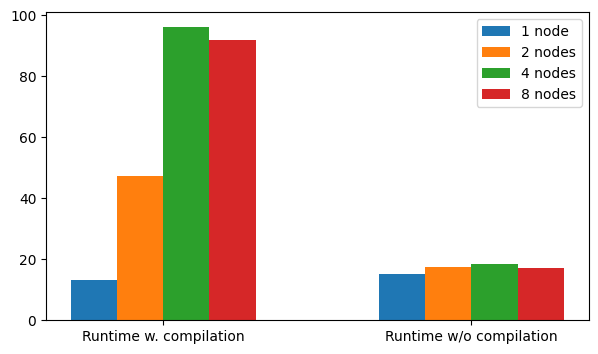

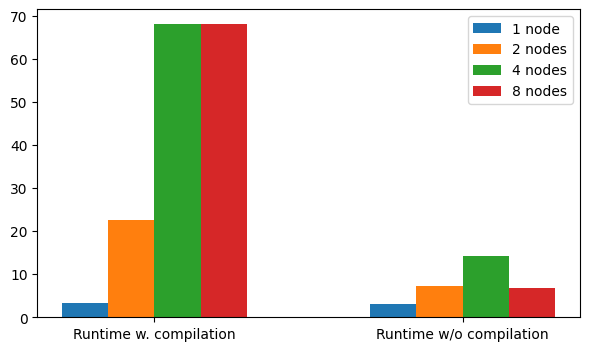

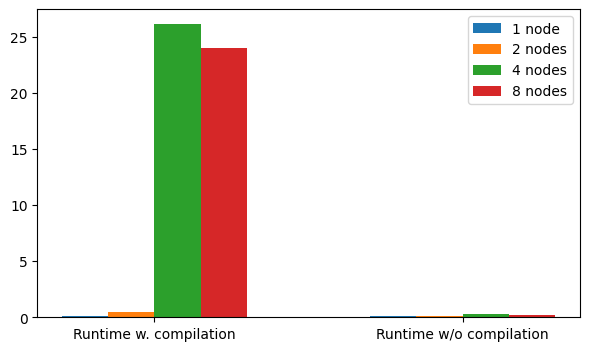

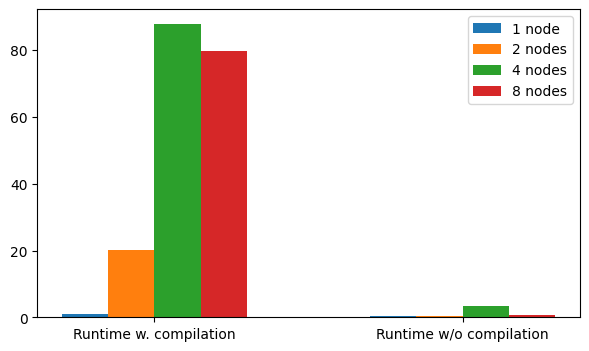

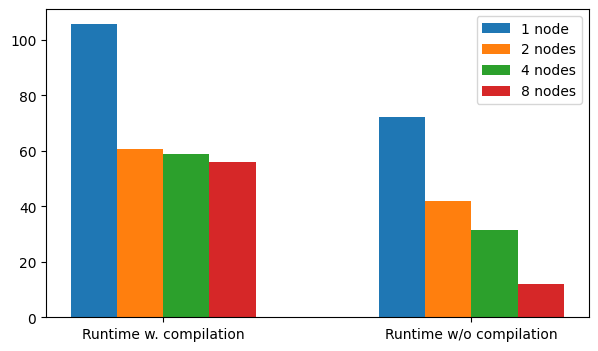

In [81]:
idx = [208, 672, 227, 197, 220, 430, 1064]
for i in idx:
    plot_per_query_runtime(i, all_first_run, all_other_runs, True)

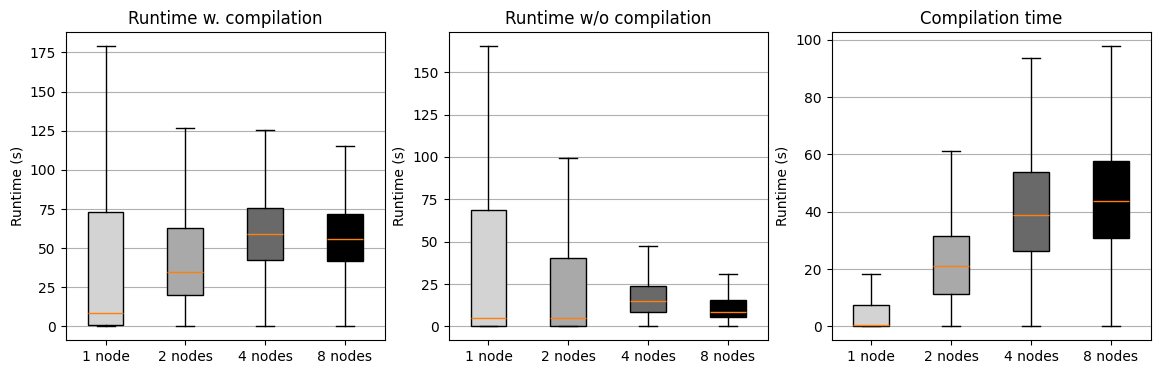

In [63]:
labels = ['1 node', '2 nodes', '4 nodes', '8 nodes']

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

# rectangular box plot
bplot1 = ax1.boxplot(all_first_run,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,
                    showfliers=False)  # will be used to label x-ticks
ax1.set_title('Runtime w. compilation')

bplot2 = ax2.boxplot(all_other_runs,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels, 
                    showfliers=False)  # will be used to label x-ticks
ax2.set_title('Runtime w/o compilation')

bplot3 = ax3.boxplot(all_compilation_time,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels, 
                    showfliers=False)  # will be used to label x-ticks
ax3.set_title('Compilation time')


# fill with colors
#olors = ['pink', 'lightblue', 'lightgreen']
colors = ['lightgrey', 'darkgrey', 'dimgrey', 'black']
for bplot in (bplot1, bplot2, bplot3):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2, ax3]:
    ax.yaxis.grid(True)
    #ax.set_xlabel('Three separate samples')
    ax.set_ylabel('Runtime (s)')
plt.savefig("nodes.pdf")
plt.show()